<center><b>SVM Solver</b></center>

This notebook describes the design of an SVM to classify a linearly non-separable data. CVXOPT library is used to solve the quadratic optimization problem in SVM.

In [3]:
#Import statements
import numpy as np
import math
import matplotlib.pyplot as plt
import cvxopt

<b>Data generation</b>

In [168]:
#Initialization

n = 100

X = np.random.uniform(low = 0, high = 1, size = (n*2,))
X = X.reshape(n, 2)
print("Shape of X vector:", X.shape)

Shape of X vector: (100, 2)


In [179]:
#Generate labels

def getCurveEqnVal(x):
    return 1.0 / 5.0 * math.sin(10 * x) + 0.3

def getCircleEqnVal(x1, x2):
    return math.pow((x2 - 0.8), 2) + math.pow((x1 - 0.5), 2)

def assignLabel(x1, x2):
    if x2 < getCurveEqnVal(x1) or getCircleEqnVal(x1, x2) < math.pow(0.15, 2):
        return 1
    return -1

Y = np.zeros(n).reshape(n, 1)

for i in range(n):
    x = X[i]
    Y[i] = assignLabel(x[0], x[1])

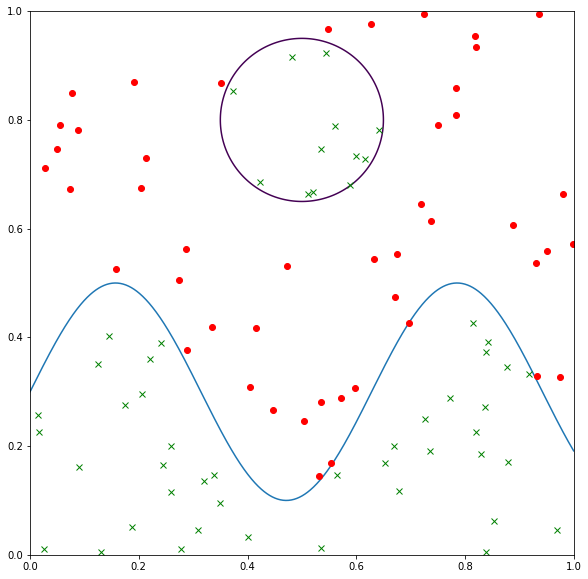

In [170]:
#Plot the input vs output
def plotGraphWithDataPoints(X, Y):
    #Step 1: Plot the graph with the curve/circle equations
    fig = plt.figure()
    ax = plt.axes()
    plt.rcParams["figure.figsize"] = [7, 7]

    #Curve equation
    x = np.linspace(0, 1, 1000)
    ax.plot(x, 1 / 5 * np.sin(10 * x) + 0.3)
    
    #Circle equation
    r = 0.15
    x_temp = np.linspace(0, 1, 1000)
    y_temp = np.linspace(0, 1, 1000)
    x, y = np.meshgrid(x_temp,y_temp)
    circle_points = ((y - 0.8) ** 2) + ((x - 0.5) ** 2) - (r ** 2)
    plt.contour(x,y,circle_points,[0])
    
    plt.gca().set_aspect('equal')
    
    for i in range(n):
        if Y[i] == 1:
            plt.plot(X[i][0], X[i][1], 'gx')
        else:
            plt.plot(X[i][0], X[i][1], 'ro')
    
    plt.show()
    
plotGraphWithDataPoints(X, Y)

<b>SVM classifier: Definition and support vectors identification for generated data</b>

In [134]:
def kernel(x, z, sigma = 1.0):
    #Gaussian kernel
    return np.exp(-sigma * (np.linalg.norm(x-z) ** 2))

In [171]:
def generateSupportVectors(X, Y, threshold = 1e-10):
    #Kernel K
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i, j] = kernel(X[i], X[j], 0.1) #sigma = 0.1 has been selected to generate the minimum number of support vectors
            
    #Defining parameters for cvxopt
    H = np.matmul(Y, Y.T) * K
    P = cvxopt.matrix(H)
    q = cvxopt.matrix(-1.0 * np.ones(X.shape[0]))
    G = cvxopt.matrix(np.eye(X.shape[0]) * -1.0)
    h = cvxopt.matrix(np.zeros(X.shape[0]))
    A = cvxopt.matrix(Y.T)
    b = cvxopt.matrix(0.0)

    cvxopt.solvers.options['show_progress'] = False
    svm_solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(svm_solution['x'])
    support_vectors = alphas > threshold #1e+04 for RBF
    return alphas, support_vectors
    
alphas, support_vectors = generateSupportVectors(X, Y)
sup_vec = np.argwhere(support_vectors == True)
print("Number of support vectors: ", len(sup_vec))

Number of support vectors:  11


In [180]:
#Extracting the data and labels corresponding to the support vectors
X_s = X[sup_vec].reshape(len(sup_vec), X.shape[1])
Y_s = Y[sup_vec].reshape(len(sup_vec), Y.shape[1])
alpha_s = alphas[sup_vec]

In [181]:
#Bias calculation
def getBias(X, Y, alpha):
    support_vector_count = alpha.shape[0]
    b = np.zeros(support_vector_count)
    for i in range(support_vector_count):
        sumVal = 0
        for j in range(support_vector_count):
            sumVal += alpha[j] * Y[j] * kernel(X[j], X[i], 0.1)
        b[i] = Y[i] - sumVal
    return np.mean(b)
    
theta = getBias(X_s, Y_s, alpha_s)

In [182]:
#Define discriminant function
def getG(X):
    support_vector_count = alpha_s.shape[0]
    sumVal = 0
    for i in range(support_vector_count):
        sumVal += alpha_s[i] * Y_s[i] * kernel(X_s[i], X, 0.1)
    G = sumVal + theta
    return G

#Sanity check for discriminant function using support vectors
misclassifications = 0
for i in range(X_s.shape[0]):
    g = getG(X_s[i])
    if round(g[0]) != Y_s[i]:
        misclassifications += 1
print("Misclassifications:", misclassifications)

Misclassifications: 0


In [175]:
x_H = np.asarray([0, 0]).reshape(1, 2)
x_Hplus = np.asarray([0, 0]).reshape(1, 2)
x_Hminus = np.asarray([0, 0]).reshape(1, 2)

#Plot the H, H+ and H- points for the graph region
x1 = 0
while x1 <= 1:
    x2 = 0
    while x2 <= 1:
        curVal = np.asarray([x1, x2]).reshape(1, 2)
        g = getG(curVal)[0]
        if g >= 0.95 and g <= 1.05:
            x_Hplus = np.append(x_Hplus, curVal, axis = 0)
        elif g >= -1.05 and g <= -0.95:
            x_Hminus = np.append(x_Hminus, curVal, axis = 0)
        elif g >= -0.05 and g <= 0.05: 
            x_H = np.append(x_H, curVal, axis = 0)
        x2 += 0.001
        x2 = round(x2, 3)
    x1 += 0.001
    x1 = round(x1, 3)

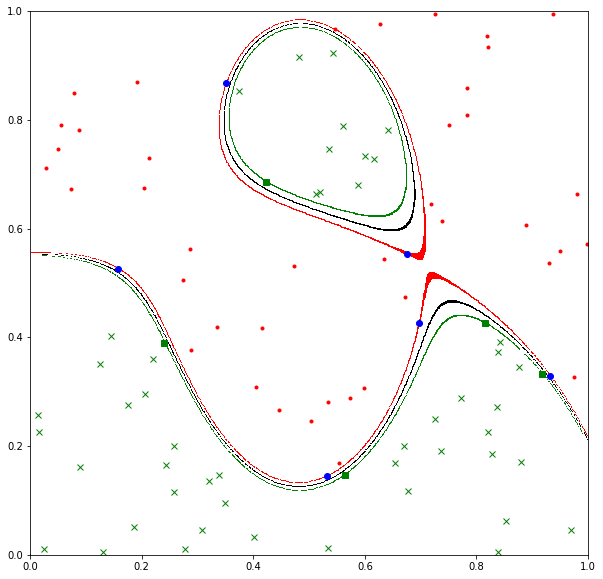

In [197]:
#Plotting the hyperplanes along with the support vectors
fig = plt.figure()
ax = plt.axes()
plt.rcParams["figure.figsize"] = [10, 10]
plt.xlim(0, 1)
plt.ylim(0, 1)
    
plt.plot(x_H[:, 0], x_H[:, 1], ',', color = 'black')
plt.plot(x_Hplus[:, 0], x_Hplus[:, 1], ',', color = 'green')
plt.plot(x_Hminus[:, 0], x_Hminus[:, 1], ',', color = 'red')

for i in range(n):
        if Y[i] == 1:
            plt.plot(X[i][0], X[i][1], 'x', color = 'green')
        else:
            plt.plot(X[i][0], X[i][1], '.', color = 'red')
            
for i in range(len(X_s)):
    if Y_s[i] == 1:
        plt.plot(X_s[i][0], X_s[i][1], 'sg')
    else:
        plt.plot(X_s[i][0], X_s[i][1], 'ob')
        
plt.show()

<ol>
    <li>
        <u>Kernel selection:</u>
        <ul>
            <li>From the visual representation of the data, it was observed that the data is not linearly separable and hence linearly kernel will not be suitable.</li>
            <li>Polynomial kernel didn't provide desirable results</li>
            <li>Hence, Gaussian kernel was chosen since it was of infinite dimensions. It provided support vectors that could classify the data without misclassifications.<center><b>K(x, z) = exp(-sigma * ||x-z||^2)</b></center></li>
        </ul>
    </li>
    <li>
        <u>Kernel parameters:</u>
        <ul>
            <li>The Gaussian kernel took one parameter 'sigma'.</li>
            <li>This parameter resulted in different Hyperplanes for different values.</li>
            <li>On setting sigma to a high value, the data points were overfit by the classifier. Generally, all data points were returned as Support Vectors on solving the dual form of SVM equation.</li>
            <li>An optimal value of <b>sigma = 0.1</b> was identified (by iteratively generating hyperplanes for different sigma values) to provide the minimum number of support vectors that could correctly classify all the data points.</li>
        </ul>
    </li>
</ol>